In [8]:
import os

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

# Pour pouvoir importer duree.py qui est dans ../code
import sys
sys.path.append('../code')

from duree import duree

# Optionnel : pour avoir des résultats reproductibles
np.random.seed(0)

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True

In [9]:
# Chargement des données réelles de pluie/sèche
mat_path = os.path.join("..", "data", "RR5MN.mat")
mat = sio.loadmat(mat_path)

ObsMesure = mat['Support'].astype(np.int8).squeeze() - 1  # 0 = sec, 1 = pluie

print("Longueur de la série mesurée :", len(ObsMesure))
print("Fréquence empirique de pluie :", np.mean(ObsMesure == 1))
print("Fréquence empirique de sec   :", np.mean(ObsMesure == 0))

Longueur de la série mesurée : 219168
Fréquence empirique de pluie : 0.04193130383997664
Fréquence empirique de sec   : 0.9580686961600233


In [5]:
# paramètres symboliques de la chaîne
alpha = 0.9   # P(pluie demain | pluie aujourd'hui)
beta  = 0.3   # P(pluie demain | sec aujourd'hui)
gamma = 0.5   # P(sec au temps 0)

A = np.array([[1-beta, beta],
              [1-alpha, alpha]])

pi0 = np.array([gamma, 1-gamma])

print("Matrice de transition A =\n", A)
print("Distribution initiale pi0 =", pi0)

Matrice de transition A =
 [[0.7 0.3]
 [0.1 0.9]]
Distribution initiale pi0 = [0.5 0.5]


In [10]:
# Calcul des durées sèches et pluvieuses sur la série mesurée
dSecMes, dPluieMes, pdfSecMes, pdfPluieMes, binsSecMes, binsPluieMes = duree(ObsMesure)

mean_sec_mes   = dSecMes.mean()
mean_pluie_mes = dPluieMes.mean()

# Paramètres géométriques estimés à partir des moyennes
# p_hat = P(sec -> pluie), q_hat = P(pluie -> sec)
p_hat = 1.0 / mean_sec_mes
q_hat = 1.0 / mean_pluie_mes

print("Nombre de périodes sèches (mesurées)     :", len(dSecMes))
print("Nombre de périodes pluvieuses (mesurées) :", len(dPluieMes))
print()
print("Durée moyenne d'une période sèche (mesurée)  :", mean_sec_mes)
print("Durée moyenne d'une période pluvieuse (mesurée):", mean_pluie_mes)
print()
print("p_hat = P(sec -> pluie)   ≈", p_hat)
print("q_hat = P(pluie -> sec)   ≈", q_hat)

Nombre de périodes sèches (mesurées)     : 1595
Nombre de périodes pluvieuses (mesurées) : 1596

Durée moyenne d'une période sèche (mesurée)  : 124.7153605015674
Durée moyenne d'une période pluvieuse (mesurée): 5.758145363408521

p_hat = P(sec -> pluie)   ≈ 0.008018258504632492
q_hat = P(pluie -> sec)   ≈ 0.1736670293797606


In [11]:
def simulate_markov(T, start_prob, Nsamples, seed=None):
    """
    Simule une chaîne de Markov à 2 états (0/1).
    T : matrice 2x2 de transition
    start_prob : distribution initiale [P(X0=0), P(X0=1)]
    Retourne : obsSeq (0/1), statesSeq (0/1)
    """
    if seed is not None:
        rng = np.random.default_rng(seed)
        choice = rng.choice
    else:
        choice = np.random.choice
    
    states = np.zeros(Nsamples, dtype=int)
    obs    = np.zeros(Nsamples, dtype=int)
    
    # état initial
    states[0] = choice([0, 1], p=start_prob)
    obs[0]    = states[0]
    
    # évolution
    for t in range(1, Nsamples):
        prev = states[t-1]
        states[t] = choice([0, 1], p=T[prev])
        obs[t]    = states[t]
    
    return obs, states


def centers_from_bins(bins):
    """Retourne les centres des classes à partir des bords des bins."""
    return (bins[:-1] + bins[1:]) / 2


def plot_durees(centers_sim, pdf_sim, centers_mes, pdf_mes,
                xlabel, title, label_sim="Simulée", label_mes="Mesurée"):
    plt.figure()
    plt.bar(centers_sim, pdf_sim, width=1, alpha=0.5, label=label_sim)
    plt.bar(centers_mes, pdf_mes, width=1, alpha=0.5, label=label_mes)
    plt.xlabel(xlabel)
    plt.ylabel("Densité")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [ ]:
# --- Modèle 1 : paramètres "de départ" (ceux donnés par le prof / choisis à la main)

gamma = 0.95  # P(X0 = sec)
alpha = 0.65  # P(sec -> sec)
beta  = 0.02  # P(pluie -> sec)   (à adapter suivant l'énoncé exact)

Nsamples = 10000

start_probability_1 = np.array([gamma, 1-gamma], dtype=float)

# Correction respectant l'énoncé : beta est la proba de RESTER dans la pluie
T1 = np.array([
    [alpha,       1.0 - alpha],  # Sec -> Sec, Sec -> Pluie
    [1.0 - beta,  beta]          # Pluie -> Sec, Pluie -> Pluie (0.02)
], dtype=float)

print("Matrice de transition T1 =\n", T1)
print("Distribution initiale =", start_probability_1)

# Simulation
obsSim1, statesSim1 = simulate_markov(T1, start_probability_1, Nsamples)

freq_pluie_sim1 = np.mean(obsSim1 == 1)
print("\nFréquence de pluie simulée (modèle 1) :", freq_pluie_sim1)

# Durées sur la série simulée
dSec1, dPluie1, pdfSec1, pdfPluie1, binsSec1, binsPluie1 = duree(obsSim1)

print("Nombre de périodes sèches (simulées, modèle 1)     :", len(dSec1))
print("Nombre de périodes pluvieuses (simulées, modèle 1) :", len(dPluie1))

Matrice de transition T1 =
 [[0.65 0.35]
 [0.02 0.98]]
Distribution initiale = [0.95 0.05]

Fréquence de pluie simulée (modèle 1) : 0.9402
Nombre de périodes sèches (simulées, modèle 1)     : 217
Nombre de périodes pluvieuses (simulées, modèle 1) : 218


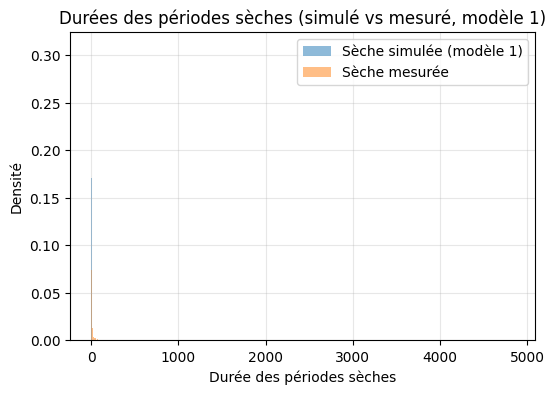

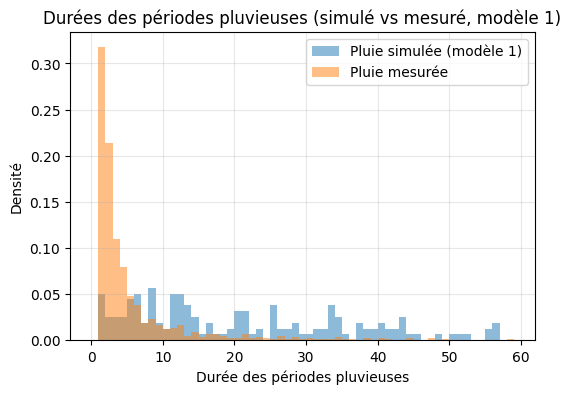

In [13]:
# Centres des classes
centersSec1      = centers_from_bins(binsSec1)
centersSecMes    = centers_from_bins(binsSecMes)
centersPluie1    = centers_from_bins(binsPluie1)
centersPluieMes  = centers_from_bins(binsPluieMes)

# Durées sèches
plot_durees(
    centersSec1, pdfSec1,
    centersSecMes, pdfSecMes,
    xlabel="Durée des périodes sèches",
    title="Durées des périodes sèches (simulé vs mesuré, modèle 1)",
    label_sim="Sèche simulée (modèle 1)",
    label_mes="Sèche mesurée"
)

# Durées pluvieuses
plot_durees(
    centersPluie1, pdfPluie1,
    centersPluieMes, pdfPluieMes,
    xlabel="Durée des périodes pluvieuses",
    title="Durées des périodes pluvieuses (simulé vs mesuré, modèle 1)",
    label_sim="Pluie simulée (modèle 1)",
    label_mes="Pluie mesurée"
)

In [14]:
# --- Modèle 2 : paramètres estimés à partir des durées mesurées (p_hat, q_hat)

p_hat = 1.0 / mean_sec_mes    # P(sec -> pluie)
q_hat = 1.0 / mean_pluie_mes  # P(pluie -> sec)

T2 = np.array([
    [1.0 - p_hat, p_hat],   # depuis sec
    [q_hat,       1.0 - q_hat]  # depuis pluie
], dtype=float)

# On initialise proche de la fréquence empirique mesurée
pi0_pluie = np.mean(ObsMesure == 1)
start_probability_2 = np.array([1 - pi0_pluie, pi0_pluie], dtype=float)

print("Matrice de transition T2 (estimée) =\n", T2)
print("Distribution initiale (estimée)    =", start_probability_2)

# Simulation
obsSim2, statesSim2 = simulate_markov(T2, start_probability_2, Nsamples)

freq_pluie_sim2 = np.mean(obsSim2 == 1)
print("\nFréquence de pluie simulée (modèle 2) :", freq_pluie_sim2)
print("Fréquence de pluie mesurée            :", np.mean(ObsMesure == 1))

# Durées sur la série simulée (modèle 2)
dSec2, dPluie2, pdfSec2, pdfPluie2, binsSec2, binsPluie2 = duree(obsSim2)

print("Nombre de périodes sèches (simulées, modèle 2)     :", len(dSec2))
print("Nombre de périodes pluvieuses (simulées, modèle 2) :", len(dPluie2))

Matrice de transition T2 (estimée) =
 [[0.99198174 0.00801826]
 [0.17366703 0.82633297]]
Distribution initiale (estimée)    = [0.9580687 0.0419313]

Fréquence de pluie simulée (modèle 2) : 0.0482
Fréquence de pluie mesurée            : 0.04193130383997664
Nombre de périodes sèches (simulées, modèle 2)     : 80
Nombre de périodes pluvieuses (simulées, modèle 2) : 81


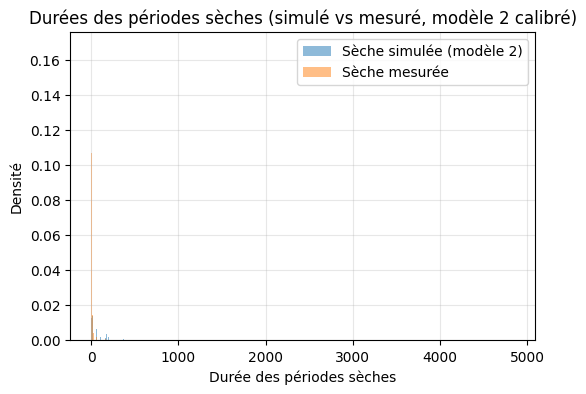

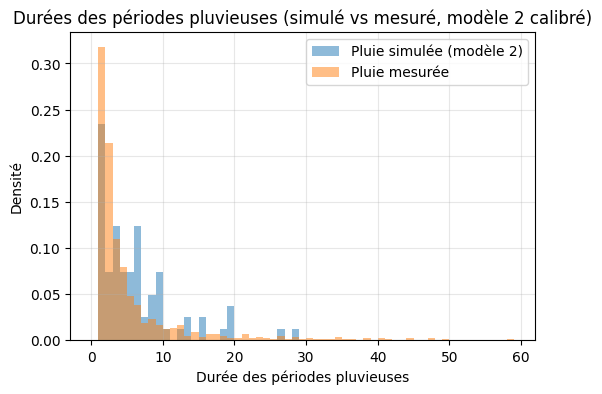

In [15]:
# Centres des classes
centersSec2      = centers_from_bins(binsSec2)
centersPluie2    = centers_from_bins(binsPluie2)

# Durées sèches
plot_durees(
    centersSec2, pdfSec2,
    centersSecMes, pdfSecMes,
    xlabel="Durée des périodes sèches",
    title="Durées des périodes sèches (simulé vs mesuré, modèle 2 calibré)",
    label_sim="Sèche simulée (modèle 2)",
    label_mes="Sèche mesurée"
)

# Durées pluvieuses
plot_durees(
    centersPluie2, pdfPluie2,
    centersPluieMes, pdfPluieMes,
    xlabel="Durée des périodes pluvieuses",
    title="Durées des périodes pluvieuses (simulé vs mesuré, modèle 2 calibré)",
    label_sim="Pluie simulée (modèle 2)",
    label_mes="Pluie mesurée"
)

In [16]:
def stationary_from_pq(p, q):
    """
    Pour une chaîne 2 états avec
      p = P(sec -> pluie)
      q = P(pluie -> sec)
    la proba stationnaire de pluie vaut  pi_pluie = p / (p + q).
    """
    pi_pluie = p / (p + q)
    pi_sec   = 1.0 - pi_pluie
    return np.array([pi_sec, pi_pluie])


# Modèle 1 (à partir de alpha, beta)
# Ici p1 = P(sec -> pluie) = 1 - alpha
#      q1 = P(pluie -> sec) = beta
p1 = 1.0 - alpha
q1 = beta
pi_star_1 = stationary_from_pq(p1, q1)

# Modèle 2 (estimé)
p2 = p_hat
q2 = q_hat
pi_star_2 = stationary_from_pq(p2, q2)

print("Proba stationnaire pluie (modèle 1) :", pi_star_1[1])
print("Proba stationnaire pluie (modèle 2) :", pi_star_2[1])
print("Fréquence empirique pluie (mesurée) :", np.mean(ObsMesure == 1))

Proba stationnaire pluie (modèle 1) : 0.9459459459459459
Proba stationnaire pluie (modèle 2) : 0.044132679084805886
Fréquence empirique pluie (mesurée) : 0.04193130383997664


In [6]:
# solution théorique de l'équation stationnaire
pi1_star_theo = beta / (1 + beta - alpha)
pi0_star_theo = 1 - pi1_star_theo
pi_star_theo = np.array([pi0_star_theo, pi1_star_theo])

print("pi* théorique =", pi_star_theo)

# vérification que pi* = pi* A
print("pi* A =", pi_star_theo @ A)

pi* théorique = [0.25 0.75]
pi* A = [0.25 0.75]
